In [2]:
import json
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 200)

In [3]:
FILE = "../data_merging/movies_merged.json"  # <-- change this

def load_movies(path: str | Path) -> list[dict]:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    assert isinstance(data, list), "Top-level JSON must be a list of movies"
    return data

raw = load_movies(FILE)

# Flatten top-level simple fields with json_normalize
df = pd.json_normalize(
    raw,
    sep=".",
    max_level=1
)

# Keep only likely-useful top-level columns (add/remove as you wish)
keep_cols = [
    "id", "title", "original_title", "overview", "release_date", "runtime",
    "budget", "revenue", "vote_average", "vote_count",
    "_ids.tmdb_id", "_ids.imdb_id", "_ids.movielens_movieId",
    "genres", "keywords", "production_companies", "spoken_languages",
    "belongs_to_collection", "cast", "crew", "ratings.movielens.count",
    "ratings.movielens.mean", "ratings.movielens.std",
]
for c in keep_cols:
    if c not in df.columns:
        df[c] = np.nan
df = df[keep_cols]


In [4]:
# Dates
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["release_year"] = df["release_date"].dt.year

# Numeric money/ratings
def to_float(x):
    if x in (None, "", np.nan):
        return np.nan
    try:
        return float(str(x).replace(",", "").strip())
    except Exception:
        return np.nan

for col in ["runtime", "budget", "revenue", "vote_average", "vote_count",
            "ratings.movielens.count", "ratings.movielens.mean", "ratings.movielens.std"]:
    df[col] = df[col].apply(to_float)

# Basic finance metrics (beware zeros)
df["profit"] = df["revenue"] - df["budget"]
df["roi"] = np.where(df["budget"] > 0, df["profit"] / df["budget"], np.nan)

# Turn list-of-dicts into list-of-names (keep ids if you prefer)
def list_of_names(col, key="name"):
    return col.apply(lambda x: [d.get(key) for d in x if isinstance(d, dict) and d.get(key)]
                     if isinstance(x, list) else [])

df["genres_names"] = list_of_names(df["genres"])
df["keywords_names"] = list_of_names(df["keywords"])
df["companies_names"] = list_of_names(df["production_companies"])
df["languages_names"] = list_of_names(df["spoken_languages"])

# Cast/crew: pull main cast names and common jobs
def cast_names(lst, top_n=5):
    if not isinstance(lst, list):
        return []
    # order key exists for cast; sort by 'order' then take top_n
    sorted_cast = sorted(
        [c for c in lst if isinstance(c, dict)],
        key=lambda d: (d.get("order", 1e9))
    )
    return [c.get("name") for c in sorted_cast[:top_n] if c.get("name")]

df["cast_top5"] = df["cast"].apply(cast_names)

def crew_by_job(lst, job="Director"):
    if not isinstance(lst, list):
        return []
    return [c.get("name") for c in lst if isinstance(c, dict) and c.get("job") == job and c.get("name")]

df["directors"] = df["crew"].apply(lambda c: crew_by_job(c, "Director"))
df["writers"] = df["crew"].apply(lambda c: crew_by_job(c, "Screenplay"))


In [5]:
print("Rows:", len(df))
print("\nColumns:", df.columns.tolist())

print("\nHead:")
display(df.head(3))

print("\nMissingness (%):")
display(df.isna().mean().sort_values(ascending=False).to_frame("missing_ratio").head(20))

print("\nDescriptive stats (numeric):")
display(df[["runtime","budget","revenue","profit","roi","vote_average","vote_count"]].describe(percentiles=[.05,.25,.5,.75,.95]))


Rows: 47568

Columns: ['id', 'title', 'original_title', 'overview', 'release_date', 'runtime', 'budget', 'revenue', 'vote_average', 'vote_count', '_ids.tmdb_id', '_ids.imdb_id', '_ids.movielens_movieId', 'genres', 'keywords', 'production_companies', 'spoken_languages', 'belongs_to_collection', 'cast', 'crew', 'ratings.movielens.count', 'ratings.movielens.mean', 'ratings.movielens.std', 'release_year', 'profit', 'roi', 'genres_names', 'keywords_names', 'companies_names', 'languages_names', 'cast_top5', 'directors', 'writers']

Head:


,id,title,original_title,overview,release_date,runtime,budget,revenue,vote_average,vote_count,...,release_year,profit,roi,genres_names,keywords_names,companies_names,languages_names,cast_top5,directors,writers
0,862.0,Toy Story,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circum...",1995-10-30,81.0,30000000.0,373554033.0,7.7,5415.0,...,1995.0,343554033.0,11.451801,"[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, rivalry, boy next door, new toy, toy comes to life]",[Pixar Animation Studios],[English],"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney, Wallace Shawn]",[John Lasseter],"[Joss Whedon, Andrew Stanton, Joel Cohen, Alec Sokolow]"
1,8844.0,Jumanji,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- in...",1995-12-15,104.0,65000000.0,262797249.0,6.9,2413.0,...,1995.0,197797249.0,3.043035,"[Adventure, Fantasy, Family]","[board game, disappearance, based on children's book, new home, recluse, giant insect]","[TriStar Pictures, Teitler Film, Interscope Communications]","[English, Français]","[Robin Williams, Jonathan Hyde, Kirsten Dunst, Bradley Pierce, Bonnie Hunt]",[Joe Johnston],"[Jonathan Hensleigh, Greg Taylor, Jim Strain]"
2,15602.0,Grumpier Old Men,Grumpier Old Men,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming t...",1995-12-22,101.0,0.0,0.0,6.5,92.0,...,1995.0,0.0,NaN,"[Romance, Comedy]","[fishing, best friend, duringcreditsstinger, old men]","[Warner Bros., Lancaster Gate]",[English],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sophia Loren, Daryl Hannah]",[Howard Deutch],[]



Missingness (%):


,missing_ratio
ratings.movielens.mean,1.000000
ratings.movielens.count,1.000000
ratings.movielens.std,1.000000
belongs_to_collection,1.000000
roi,0.808001
overview,0.020917
runtime,0.019446
release_year,0.015662
release_date,0.015662
vote_count,0.013896



Descriptive stats (numeric):


,runtime,budget,revenue,profit,roi,vote_average,vote_count
count,46643.000000,4.691100e+04,4.690700e+04,4.690700e+04,9.133000e+03,46907.000000,46907.000000
mean,94.123448,4.160363e+06,1.099107e+07,6.830354e+06,3.278364e+03,5.611525,107.782271
std,38.382229,1.723739e+07,6.362390e+07,5.157266e+07,1.664714e+05,1.932251,485.017943
min,0.000000,0.000000e+00,0.000000e+00,-1.657101e+08,-1.000000e+00,0.000000,0.000000
5%,11.000000,0.000000e+00,0.000000e+00,-4.700000e+06,-1.000000e+00,0.000000,0.000000
25%,85.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,5.000000,3.000000
50%,95.000000,0.000000e+00,0.000000e+00,0.000000e+00,-5.265678e-01,6.000000,10.000000
75%,107.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.578497e+00,6.800000,34.000000
95%,137.000000,2.500000e+07,4.619787e+07,2.732847e+07,8.980918e+00,7.800000,421.000000
max,1256.000000,3.800000e+08,2.787965e+09,2.550965e+09,1.239638e+07,10.000000,14075.000000


In [6]:
def freq_from_list_column(series_of_lists, top=20):
    counter = Counter()
    for lst in series_of_lists.dropna():
        for item in (lst if isinstance(lst, list) else []):
            if item:
                counter[item] += 1
    return pd.DataFrame(counter.most_common(top), columns=["item","count"])

top_genres = freq_from_list_column(df["genres_names"], 20)
top_keywords = freq_from_list_column(df["keywords_names"], 20)
top_companies = freq_from_list_column(df["companies_names"], 20)
top_languages = freq_from_list_column(df["languages_names"], 20)
top_directors = freq_from_list_column(df["directors"], 20)

print("Top Genres:")
display(top_genres)

print("Top Keywords:")
display(top_keywords)

print("Top Production Companies:")
display(top_companies)

print("Top Languages:")
display(top_languages)

print("Top Directors:")
display(top_directors)


Top Genres:


,item,count
0,Drama,20977
1,Comedy,13515
2,Thriller,7872
3,Romance,6963
4,Action,6762
5,Horror,4778
6,Crime,4411
7,Documentary,4070
8,Adventure,3635
9,Science Fiction,3180


Top Keywords:


,item,count
0,woman director,3144
1,independent film,1958
2,murder,1322
3,based on novel,849
4,musical,734
5,sex,685
6,biography,657
7,violence,651
8,nudity,636
9,revenge,626


Top Production Companies:


,item,count
0,Warner Bros.,1256
1,Metro-Goldwyn-Mayer (MGM),1110
2,Paramount Pictures,1041
3,Twentieth Century Fox Film Corporation,841
4,Universal Pictures,836
5,Canal+,470
6,Columbia Pictures Corporation,451
7,Columbia Pictures,434
8,RKO Radio Pictures,292
9,United Artists,281


Top Languages:


,item,count
0,English,29429
1,Français,4340
2,Deutsch,2690
3,Español,2460
4,Italiano,2429
5,日本語,1847
6,Pусский,1583
7,普通话,810
8,हिन्दी,749
9,Português,614


Top Directors:


,item,count
0,JP Siili,85
1,John Ford,69
2,Michael Curtiz,66
3,Anatole Litvak,63
4,Frank Capra,59
5,Werner Herzog,56
6,George Cukor,54
7,Julien Duvivier,54
8,Alfred Hitchcock,53
9,Georges Méliès,51


In [7]:
# Example: genre → movie mapping
genres_exploded = df[["id","title","release_year","vote_average","revenue","budget","roi","genres_names"]].explode("genres_names")
genres_exploded.rename(columns={"genres_names":"genre"}, inplace=True)

# Keyword exploded
keywords_exploded = df[["id","title","release_year","keywords_names"]].explode("keywords_names")
keywords_exploded.rename(columns={"keywords_names":"keyword"}, inplace=True)

# Director exploded
directors_exploded = df[["id","title","release_year","directors","roi","revenue","vote_average"]].explode("directors")
directors_exploded.rename(columns={"directors":"director"}, inplace=True)

display(genres_exploded.head(5))
display(keywords_exploded.head(5))
display(directors_exploded.head(5))


,id,title,release_year,vote_average,revenue,budget,roi,genre
0,862.0,Toy Story,1995.0,7.7,373554033.0,30000000.0,11.451801,Animation
0,862.0,Toy Story,1995.0,7.7,373554033.0,30000000.0,11.451801,Comedy
0,862.0,Toy Story,1995.0,7.7,373554033.0,30000000.0,11.451801,Family
1,8844.0,Jumanji,1995.0,6.9,262797249.0,65000000.0,3.043035,Adventure
1,8844.0,Jumanji,1995.0,6.9,262797249.0,65000000.0,3.043035,Fantasy


,id,title,release_year,keyword
0,862.0,Toy Story,1995.0,jealousy
0,862.0,Toy Story,1995.0,toy
0,862.0,Toy Story,1995.0,boy
0,862.0,Toy Story,1995.0,friendship
0,862.0,Toy Story,1995.0,friends


,id,title,release_year,director,roi,revenue,vote_average
0,862.0,Toy Story,1995.0,John Lasseter,11.451801,373554033.0,7.7
1,8844.0,Jumanji,1995.0,Joe Johnston,3.043035,262797249.0,6.9
2,15602.0,Grumpier Old Men,1995.0,Howard Deutch,NaN,0.0,6.5
3,31357.0,Waiting to Exhale,1995.0,Forest Whitaker,4.090760,81452156.0,6.1
4,11862.0,Father of the Bride Part II,1995.0,Charles Shyer,NaN,76578911.0,5.7


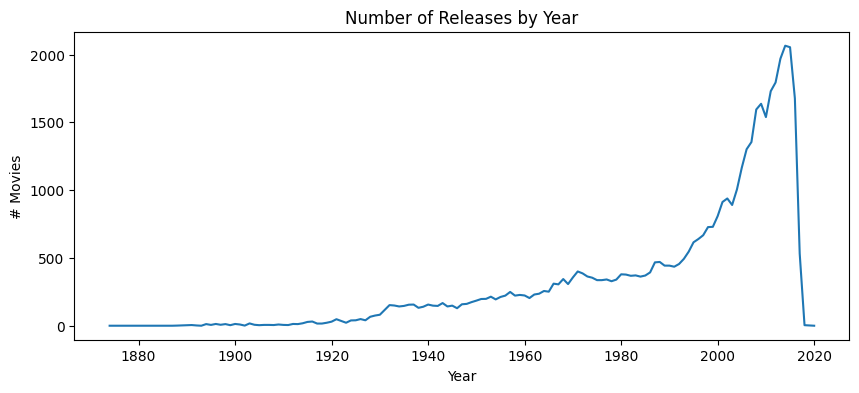

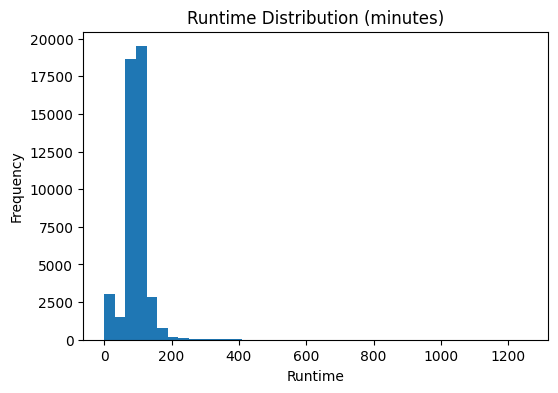

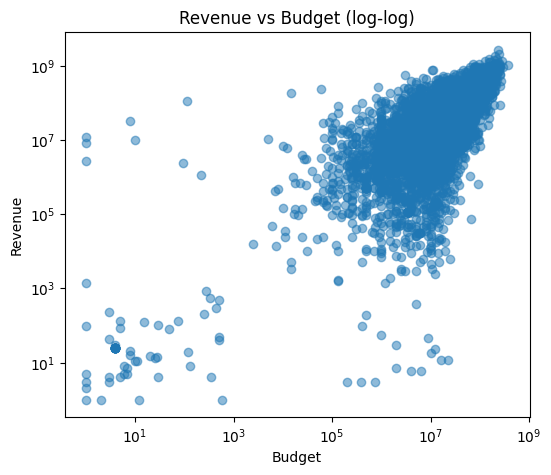

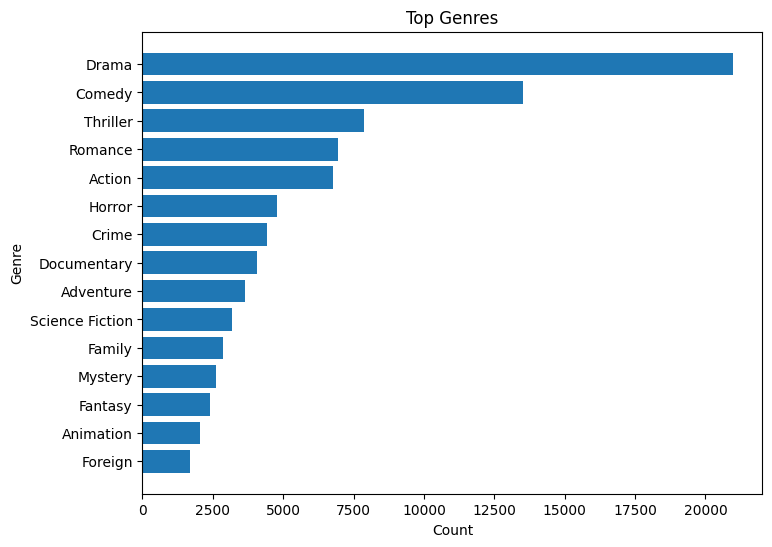

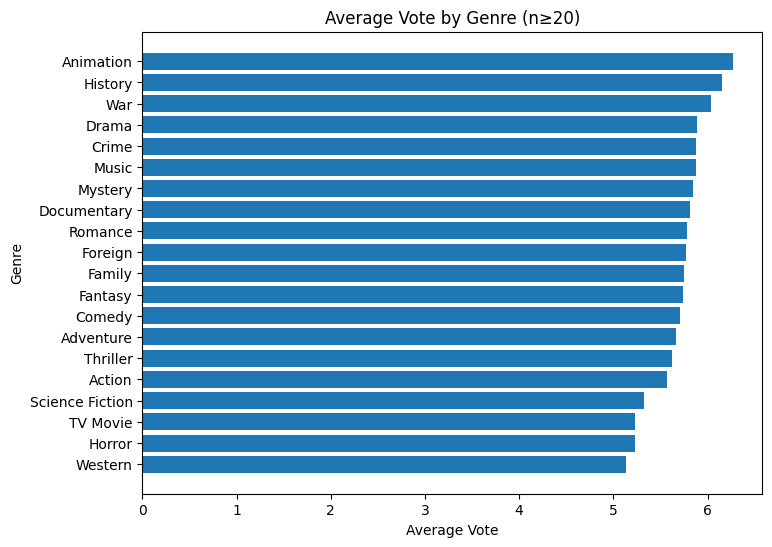

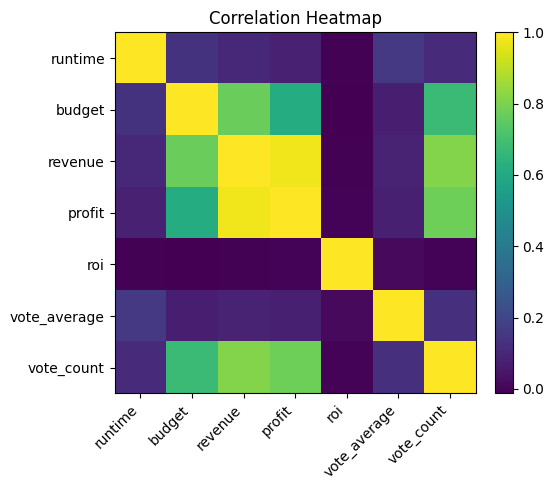

In [8]:
# 7.1 Release count by year
counts_by_year = df.groupby("release_year")["id"].count().dropna()
plt.figure(figsize=(10,4))
plt.plot(counts_by_year.index, counts_by_year.values)
plt.title("Number of Releases by Year")
plt.xlabel("Year")
plt.ylabel("# Movies")
plt.show()

# 7.2 Distribution of runtimes
plt.figure(figsize=(6,4))
df["runtime"].dropna().plot(kind="hist", bins=40)
plt.title("Runtime Distribution (minutes)")
plt.xlabel("Runtime")
plt.ylabel("Frequency")
plt.show()

# 7.3 Revenue vs Budget scatter (log-scale)
mask = (df["budget"] > 0) & (df["revenue"] > 0)
sub = df.loc[mask, ["budget","revenue"]]
plt.figure(figsize=(6,5))
plt.scatter(sub["budget"], sub["revenue"], alpha=0.5)
plt.xscale("log"); plt.yscale("log")
plt.title("Revenue vs Budget (log-log)")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.show()

# 7.4 Top 15 genres by count
gcounts = genres_exploded["genre"].value_counts().head(15)[::-1]
plt.figure(figsize=(8,6))
plt.barh(gcounts.index, gcounts.values)
plt.title("Top Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

# 7.5 Average vote per genre (min N=20)
agg = genres_exploded.groupby("genre").agg(
    n=("id","count"),
    avg_vote=("vote_average","mean")
).query("n >= 20").sort_values("avg_vote", ascending=True).tail(20)
plt.figure(figsize=(8,6))
plt.barh(agg.index, agg["avg_vote"])
plt.title("Average Vote by Genre (n≥20)")
plt.xlabel("Average Vote")
plt.ylabel("Genre")
plt.show()

# 7.6 Correlations among numeric vars
num = df[["runtime","budget","revenue","profit","roi","vote_average","vote_count"]].copy()
corr = num.corr(numeric_only=True)
plt.figure(figsize=(6,5))
im = plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [9]:
# Best ROI movies with reasonable budget (avoid tiny or zero budgets)
best_roi = df.query("budget >= 1e6 and vote_count >= 100").sort_values("roi", ascending=False).head(10)
display(best_roi[["title","release_year","budget","revenue","roi","vote_average","vote_count"]])

# Highest grossing per year
top_rev_by_year = df.loc[df.groupby("release_year")["revenue"].idxmax().dropna().astype(int)]
display(top_rev_by_year[["release_year","title","revenue","budget","vote_average"]].sort_values("release_year"))

# Directors with most titles (top 20)
dir_freq = directors_exploded["director"].value_counts().head(20)
display(dir_freq.to_frame("count"))


,title,release_year,budget,revenue,roi,vote_average,vote_count
1024,Alice in Wonderland,1951.0,3000000.0,572000000.0,189.666667,7.0,1557.0
587,Snow White and the Seven Dwarfs,1937.0,1488423.0,184925486.0,123.242561,6.9,1973.0
1873,Rocky,1976.0,1000000.0,117235147.0,116.235147,7.5,1843.0
18630,The Devil Inside,2012.0,1000000.0,101758490.0,100.758490,4.6,263.0
907,Gone with the Wind,1939.0,4000000.0,400176459.0,99.044115,7.7,995.0
2570,The Rocky Horror Picture Show,1975.0,1200000.0,112892319.0,93.076932,7.4,703.0
1014,Cinderella,1950.0,2900000.0,263591415.0,89.893591,6.8,1760.0
8321,Saw,2004.0,1200000.0,103911669.0,85.593058,7.2,2255.0
1086,E.T. the Extra-Terrestrial,1982.0,10500000.0,792965326.0,74.520507,7.3,3359.0
5221,My Big Fat Greek Wedding,2002.0,5000000.0,368744044.0,72.748809,6.2,686.0


,release_year,title,revenue,budget,vote_average
35815,1874.0,Passage of Venus,0.000000e+00,0.0,6.0
35812,1878.0,Sallie Gardner at a Gallop,0.000000e+00,0.0,6.2
43683,1883.0,Buffalo Running,0.000000e+00,0.0,5.4
35808,1887.0,Man Walking Around a Corner,0.000000e+00,0.0,4.1
35809,1888.0,Accordion Player,0.000000e+00,0.0,4.4
...,...,...,...,...,...
27163,2015.0,Star Wars: The Force Awakens,2.068224e+09,245000000.0,7.5
27175,2016.0,Captain America: Civil War,1.153304e+09,250000000.0,7.1
44303,2017.0,Beauty and the Beast,1.262886e+09,160000000.0,6.8
31256,2018.0,Bad Boys for Life,0.000000e+00,0.0,0.0


,count
director,
JP Siili,85
John Ford,69
Michael Curtiz,66
Anatole Litvak,63
Frank Capra,59
Werner Herzog,56
Julien Duvivier,54
George Cukor,54
Alfred Hitchcock,53
